<a href="https://colab.research.google.com/github/Rstam59/ds-portfolio/blob/main/NLP_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment Analysis

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M298Y5_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M298Y5_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.M298Y5_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


In [ ]:
vocab_size = 1000

text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size,
                                                   standardize="lower_and_strip_punctuation",
                                                   split = 'whitespace')

text_vec_layer.adapt(train_set.map(lambda review, label: review))

In [ ]:
list(map(str, text_vec_layer.get_vocabulary()[:20]))

['',
 '[UNK]',
 'the',
 'and',
 'a',
 'of',
 'to',
 'is',
 'in',
 'it',
 'i',
 'this',
 'that',
 'br',
 'was',
 'as',
 'for',
 'with',
 'movie',
 'but']

In [ ]:
text_vec_layer(['it was a great movie',
                'it was'])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 9, 14,  4, 86, 18],
       [ 9, 14,  0,  0,  0]])>

In [ ]:
embed_layer = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=64)
# embed_layer(text_vec_layer(['it was a great movie']))

In [ ]:
embed_size = 128

model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_size, mask_zero = True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [ ]:
model.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3),
    metrics = ['accuracy']
)

model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - accuracy: 0.6317 - loss: 0.6197 - val_accuracy: 0.8400 - val_loss: 0.3799
Epoch 2/2
704/704 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - accuracy: 0.8533 - loss: 0.3477 - val_accuracy: 0.8736 - val_loss: 0.3060


In [ ]:
embedding_weights = model.layers[1].get_weights()[0]

In [ ]:
import numpy as np
np.savetxt("embeddings.tsv", embedding_weights, delimiter="\t")

In [ ]:
vocab = text_vec_layer.get_vocabulary()

with open("metadata.tsv", "w", encoding="utf-8") as f:
    for word in vocab:
        word = word if word.strip() != "" else "<PAD>"
        f.write(f"{word}\n")


# Generating Shakespearean Text Using a Character RNN

In [ ]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [ ]:
''.join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [ ]:
text_vec_layer = tf.keras.layers.TextVectorization(split = 'character',
                                                   standardize = 'lower')

text_vec_layer.adapt(shakespeare_text)
encoded = text_vec_layer([shakespeare_text][0])

In [ ]:
encoded -= 2
vocab_size = text_vec_layer.vocabulary_size() - 2
dataset_size = len(encoded)

In [ ]:
# input ->  Before we proceed any furthe
# output -> efore we proceed any further

In [ ]:
def to_dataset(sequence, length, seed = None, shuffle = False, batch_size = 32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift = 1, drop_remainder= True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed = seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [ ]:
import tensorflow as tf

sequence = tf.constant([10, 20, 30, 40, 50, 60, 70, 80], dtype=tf.int32)
length = 4  # input length
batch_size = 2


In [ ]:
ds = tf.data.Dataset.from_tensor_slices(sequence)
print("Step 1: from_tensor_slices")
for x in ds:
    print(x.numpy())


Step 1: from_tensor_slices
10
20
30
40
50
60
70
80


In [ ]:
ds = ds.window(length + 1, shift=1, drop_remainder=True)
print("\nStep 2: window")
for i, window_ds in enumerate(ds):
    print(f"Window {i+1}:", [int(el) for el in window_ds.as_numpy_iterator()])



Step 2: window
Window 1: [10, 20, 30, 40, 50]
Window 2: [20, 30, 40, 50, 60]
Window 3: [30, 40, 50, 60, 70]
Window 4: [40, 50, 60, 70, 80]


In [ ]:
ds = ds.flat_map(lambda window: window.batch(length + 1))
print("\nStep 3: flat_map + batch")
for x in ds:
    print(x.numpy())



Step 3: flat_map + batch
[10 20 30 40 50]
[20 30 40 50 60]
[30 40 50 60 70]
[40 50 60 70 80]


In [ ]:
ds = ds.batch(batch_size)
print("\nStep 4: batching")
for batch in ds:
    print(batch.numpy())



Step 4: batching
[[10 20 30 40 50]
 [20 30 40 50 60]]
[[30 40 50 60 70]
 [40 50 60 70 80]]


In [ ]:
ds = ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)
print("\nStep 5: split into input and target")
for input_seq, target_seq in ds:
    print("Input:", input_seq.numpy())
    print("Target:", target_seq.numpy())



Step 5: split into input and target
Input: [[10 20 30 40]
 [20 30 40 50]]
Target: [[20 30 40 50]
 [30 40 50 60]]
Input: [[30 40 50 60]
 [40 50 60 70]]
Target: [[40 50 60 70]
 [50 60 70 80]]


In [ ]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

In [ ]:
train_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None))>

In [ ]:
# input ->  Before we proceed any furthe
# output -> efore we proceed any further

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences = True),
    tf.keras.layers.Dense(vocab_size, activation="softmax")
])


model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Nadam(learning_rate=1e-3),
    metrics = ['accuracy']
)


model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model.keras", monitor="val_accuracy", save_best_only=True)


model.fit(
    train_set,
    validation_data=valid_set,
    epochs=1,
    callbacks=[model_ckpt]
)

  31245/Unknown 366s 11ms/step - accuracy: 0.5464 - loss: 1.5010

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31247/31247 ━━━━━━━━━━━━━━━━━━━━ 382s 12ms/step - accuracy: 0.5464 - loss: 1.5010 - val_accuracy: 0.5366 - val_loss: 1.5917


In [ ]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

In [ ]:
y_proba = shakespeare_model.predict(tf.constant(['To be or not to b']))[0, -1]
y_pred = tf.argmax(y_proba)
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


np.str_('e')

#Generating Fake Shakespearean text

In [ ]:
log_probas = tf.math.log([[0.5, 0.3, 0.2]])
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 0, 1, 2, 1, 0, 0, 0]])>

In [ ]:
def next_char(text, temperature = 1):
    text = tf.constant([text])
    y_proba = shakespeare_model.predict(text)[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples = 1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [ ]:
def extent_text(text, chars = 50, temperature = 1):
    for _ in range(chars):
        text += next_char(text, temperature)
    return text

In [ ]:
extent_text('to be or not to', chars = 100, temperature = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━

'to be or not to-come\nfifty warners i not of her joer trift\nas supviced,\nif you spit a pretty villain,\nburd in a pra'

In [ ]:
def next_char(text, temperature):
    text = tf.constant([text])
    y_proba = shakespeare_model.predict(text)[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples = 1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [ ]:
def extent_text(text, chars = 50, temperature = 1):
    for _ in range(chars):
        text += next_char(text, temperature)
    return text

In [ ]:
extent_text('to be or not to b', chars = 100, temperature = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━

"to be or not to bro\nnot enterate have say her to play\ntrue; i'll as's so; for we hid\nas as should pity as the poor fr"

In [ ]:
extent_text('to be or not to b', chars = 100, temperature = 0.1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━

'to be or not to be so make thee\nto see the world to him and then i will hear you and the duke is the sun\nbelieve thee'

In [ ]:
extent_text('to be or not to b', chars = 50, temperature = 0.001)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━

'to be or not to be so to him\nand then i will not show your come to '

In [ ]:
def next_char(text, temperature):
    text = tf.constant([text])
    y_proba = shakespeare_model.predict(text)[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [ ]:
def extent_text(text, chars = 50, temperature = 1):
    for _ in range(chars):
        text += next_char(text, temperature)
    return text

In [ ]:
extent_text('to be or not to be', temperature = 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

'to be or not to be so.\n\nduke vincentio:\nso from his offence be ever '

In [ ]:
extent_text('to be or not to be', chars= 10, temperature = 100)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


'to be or not to beqsn&e:csb-'

# An Encoder–Decoder Network for Neural Machine Translation

In [ ]:
from pathlib import Path
import tensorflow as tf

url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets", extract=True)

# Final corrected path
spa_txt_path = Path(path).parent / "spa-eng_extracted" / "spa-eng" / "spa.txt"

# Read the file
text = spa_txt_path.read_text(encoding='utf-8')
print(text[:500])  # Print first 500 characters as a quick check


2638744/2638744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Go.	Ve.
Go.	Vete.
Go.	Vaya.
Go.	Váyase.
Hi.	Hola.
Run!	¡Corre!
Run.	Corred.
Who?	¿Quién?
Fire!	¡Fuego!
Fire!	¡Incendio!
Fire!	¡Disparad!
Help!	¡Ayuda!
Help!	¡Socorro! ¡Auxilio!
Help!	¡Auxilio!
Jump!	¡Salta!
Jump.	Salte.
Stop!	¡Parad!
Stop!	¡Para!
Stop!	¡Pare!
Wait!	¡Espera!
Wait.	Esperen.
Go on.	Continúa.
Go on.	Continúe.
Hello!	Hola.
I ran.	Corrí.
I ran.	Corría.
I try.	Lo intento.
I won!	¡He ganado!
Oh no!	¡Oh, no!
Relax.	Tomátelo con soda.
Smile.	Sonríe.
Attack!	¡Al ataque!
Attack!	¡Atacad!
Ge


In [ ]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [ ]:
for i in range(3):
    print(sentences_en[i], '=>', sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [ ]:
vocab_size = 1000
max_length = 50

text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length,
    pad_to_max_tokens=True
)

text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length,
    pad_to_max_tokens=True
)

text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f'startofseq {s} endofseq' for s in sentences_es])

In [ ]:
text_vec_layer_en.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('the'),
 np.str_('i'),
 np.str_('to'),
 np.str_('you'),
 np.str_('tom'),
 np.str_('a'),
 np.str_('is'),
 np.str_('he')]

In [ ]:
text_vec_layer_es.get_vocabulary()[:10]

['',
 '[UNK]',
 np.str_('startofseq'),
 np.str_('endofseq'),
 np.str_('de'),
 np.str_('que'),
 np.str_('a'),
 np.str_('no'),
 np.str_('tom'),
 np.str_('la')]

In [ ]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f'startofseq {s}' for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f'startofseq {s}' for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f'{s} endofseq' for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f'{s} endofseq' for s in sentences_es[100_000:]])

In [ ]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 128

encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size,
                                                    mask_zero = True)

decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size,
                                                    mask_zero = True)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state = True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences = True)
decoder_outputs = decoder(decoder_embeddings, initial_state = encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation = 'softmax')
Y_proba = output_layer(decoder_outputs)

model = tf.keras.Model(inputs = [encoder_inputs, decoder_inputs],
                       outputs = [Y_proba])

model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'nadam',
              metrics = ['accuracy'])

model.fit((X_train, X_train_dec), Y_train, epochs = 3,
          validation_data = ((X_valid, X_valid_dec), Y_valid))

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 80s 24ms/step - accuracy: 0.0520 - loss: 3.4753 - val_accuracy: 0.0752 - val_loss: 2.1121
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 78s 23ms/step - accuracy: 0.0797 - loss: 1.9349 - val_accuracy: 0.0878 - val_loss: 1.5922
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 83s 24ms/step - accuracy: 0.0919 - loss: 1.4460 - val_accuracy: 0.0929 - val_loss: 1.4063


In [ ]:
def translate(sentence_en):
    translation = ''
    X = tf.constant([sentence_en])

    for word_idx in range(max_length):
        X_dec = tf.constant(['startofseq' + translation])
        y_proba = model.predict((X, X_dec))[0, word_idx]
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == 'endofseq':
            break
        translation += ' ' + predicted_word

    return translation.strip()

In [ ]:
translate('i like soccer and also going to the beach')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


'me gusta el fútbol y me gusta la lluvia'

In [ ]:
translate('i like soccer and also going to the beach')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


'me gusta jugar al fútbol y la [UNK]'

# Bidirectional RNNs

In [ ]:
tf.random.set_seed(42)
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True)
)

In [ ]:
# encoder_outputs, *encoder_state = encoder(encoder_embeddings)
# encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
#                  tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
class ConcatenateStates(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()
    def call(self, encoder_state):
        return [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

encoder_outputs, *encoder_state = encoder(encoder_embeddings)
concat_states = ConcatenateStates()
encoder_state = concat_states(encoder_state)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"]
)

model.fit((X_train, X_train_dec), Y_train, epochs=3,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 76s 23ms/step - accuracy: 0.0652 - loss: 2.8152 - val_accuracy: 0.0894 - val_loss: 1.5434
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 88s 25ms/step - accuracy: 0.0929 - loss: 1.4268 - val_accuracy: 0.0951 - val_loss: 1.3266
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 71s 23ms/step - accuracy: 0.1002 - loss: 1.1599 - val_accuracy: 0.0968 - val_loss: 1.2641


In [ ]:
translate('i like cats and dogs')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


'me gustan los gatos y los gatos'

#Beam Search

In [ ]:

def beam_search(sentence_en, beam_width, verbose=False):
    X = tf.constant([sentence_en])  # encoder input
    X_dec = tf.constant(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]

    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = tf.constant([sentence_en])  # encoder input
            X_dec = tf.constant(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()


In [ ]:
sentence_en = "i like cats and dogs"
translate(sentence_en)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


'me gustan los gatos y los gatos'

In [ ]:
beam_search(sentence_en, beam_width=3, verbose=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Top first words: [(np.float32(-0.33324844), np.str_('me')), (np.float32(-2.4522793), np.str_('a')), (np.float32(-3.090056), np.str_('los'))]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Top translations so far: [(np.float32(-0.37378892), 'me gustan'), (np.float32(-2.6643589), 'a los'), (np.float32(-3.3859997), 'los gatos')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Top translations so far: [(np.float32(-0.47701788), 'me gustan los'), (np.float32(-3.036123), 'a los gatos'), (np.float32(-3.4793236), 'me gustan tanto')]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Top translations so far: [(np.float32(-0.7904078), 'me gustan los gatos'), (np.float32(-2.1084514), 'me gustan los perros'), (np.float32(-3.6563306), 'a los gatos les')]
1/1 ━━━━━━━━━━

'me gustan los gatos y los gatos'

# Attention Mechanisms

In [ ]:
tf.random.set_seed(42)
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 128

encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)

encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size)

decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size)

encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences = True, return_state=True)
)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = concat_states(encoder_state)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences = True)
decoder_outputs = decoder(decoder_embeddings, initial_state = encoder_state)

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=3,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 92s 28ms/step - accuracy: 0.8990 - loss: 0.6474 - val_accuracy: 0.9435 - val_loss: 0.2596
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 141s 28ms/step - accuracy: 0.9470 - loss: 0.2382 - val_accuracy: 0.9540 - val_loss: 0.1984
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 143s 28ms/step - accuracy: 0.9557 - loss: 0.1889 - val_accuracy: 0.9570 - val_loss: 0.1823


In [ ]:
translate('i love soccer and also going to the beach')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


'me gusta fútbol y también va a la playa'

In [ ]:
attention_layer = tf.keras.layers.MultiHeadAttention(num_heads = 1, key_dim = embed_size)
attention_outputs = attention_layer(
    query = decoder_outputs,
    value = encoder_outputs,
    key = encoder_outputs)

output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=3,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 91s 27ms/step - accuracy: 0.0500 - loss: 3.6704 - val_accuracy: 0.0828 - val_loss: 1.9187
Epoch 2/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 136s 26ms/step - accuracy: 0.0860 - loss: 1.7924 - val_accuracy: 0.0907 - val_loss: 1.5603
Epoch 3/3
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 25ms/step - accuracy: 0.0932 - loss: 1.4847 - val_accuracy: 0.0943 - val_loss: 1.4230


In [ ]:
sentence_en = "I love soccer and also going to the beach"
translate(sentence_en)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


'me gusta el fútbol y voy a la playa'

# Attention Is All You Need: The Transformer Architecture
# Positional encodings

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]



In [ ]:


pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)


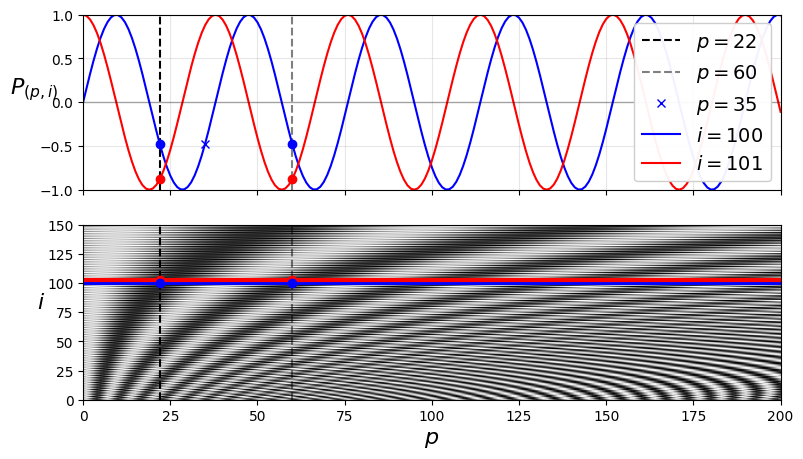

In [ ]:
import matplotlib.pyplot as plt
# extra code – this cells generates and saves Figure 16–9
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
plt.show()


# Transformer model

In [ ]:
import tensorflow as tf

vocab_size = 10000
max_length = 50
embed_size = 128
num_heads = 5
ff_dim = 512

#Input layers
encoder_inputs = tf.keras.Input(shape=(None,), dtype=tf.int32, name="encoder_inputs")
decoder_inputs = tf.keras.Input(shape=(None,), dtype=tf.int32, name="decoder_inputs")



#Embedding layer
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size,
                                                    mask_zero = True)

decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                                    output_dim = embed_size,
                                                    mask_zero = True)

encoder_embeddings = encoder_embedding_layer(encoder_inputs)
decoder_embeddings = decoder_embedding_layer(decoder_inputs)


#Positional embeddings
pos_embedding_layer = tf.keras.layers.Embedding(max_length, embed_size)
positions_encoder = tf.keras.layers.Lambda(lambda x: tf.range(start = 0, limit = tf.shape(x)[1], delta = 1))(encoder_inputs)
positions_decoder = tf.keras.layers.Lambda(lambda x: tf.range(start = 0, limit = tf.shape(x)[1], delta = 1))(decoder_inputs)
pos_embed_enc = pos_embedding_layer(positions_encoder)
pos_embed_dec = pos_embedding_layer(positions_decoder)

#Add tokens and positional embeddings
encoder_embed = encoder_embeddings + pos_embed_enc
decoder_embed = decoder_embeddings + pos_embed_dec


#Encoder self-attention
encoder_attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_size)(encoder_embed, encoder_embed)
encoder_attention = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(encoder_embed + encoder_attention)

#Encoder Feed-forward
encoder_ff = tf.keras.layers.Dense(ff_dim, activation = 'relu')(encoder_attention)
encoder_ff = tf.keras.layers.Dense(embed_size)(encoder_ff)
encoder_outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(encoder_attention + encoder_ff)


#Decoder self-attention
causal_mask = tf.keras.layers.Lambda(
    lambda x: tf.linalg.band_part(tf.ones((tf.shape(x)[1], tf.shape(x)[1])), -1, 0)
)(decoder_inputs)
decoder_attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim=embed_size)(decoder_embed, decoder_embed, attention_mask = causal_mask)
decoder_attention = tf.keras.layers.LayerNormalization(epsilon= 1e-6)(decoder_embed + decoder_attention)

#Encoder-Decoder Cross Attention
cross_attention = tf.keras.layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_size)(decoder_attention, encoder_outputs, encoder_outputs)
decoder_cross = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(decoder_attention + cross_attention)



#Decoder feed-forward
decoder_ff = tf.keras.layers.Dense(ff_dim, activation = 'relu')(decoder_cross)
decoder_ff = tf.keras.layers.Dense(embed_size)(decoder_ff)
decoder_outputs = tf.keras.layers.LayerNormalization(epsilon = 1e-6)(decoder_cross + decoder_ff)


#Final output layer
output_logits = tf.keras.layers.Dense(vocab_size, activation = 'softmax')(decoder_outputs)

#Model
transformer = tf.keras.Model([encoder_inputs, decoder_inputs], output_logits)

In [ ]:
transformer.compile(
    loss="sparse_categorical_crossentropy",
    optimizer="nadam",
    metrics=["accuracy"]
)

# transformer.fit((X_train, X_train_dec), Y_train, epochs=3,
#           validation_data=((X_valid, X_valid_dec), Y_valid))

In [ ]:
vocab_size = 15000
max_length = 50

text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length,
    pad_to_max_tokens=True
)

text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length = max_length,
    pad_to_max_tokens=True
)

text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f'startofseq {s} endofseq' for s in sentences_es])

In [ ]:
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(
    text_vec_layer_en(X_train).numpy(), padding="post", maxlen=max_length
)
X_train_dec_padded = tf.keras.preprocessing.sequence.pad_sequences(
    text_vec_layer_es(X_train_dec).numpy(), padding="post", maxlen=max_length
)

X_valid_padded = tf.keras.preprocessing.sequence.pad_sequences(
    text_vec_layer_en(X_valid).numpy(), padding="post", maxlen=max_length
)
X_valid_dec_padded = tf.keras.preprocessing.sequence.pad_sequences(
    text_vec_layer_es(X_valid_dec).numpy(), padding="post", maxlen=max_length
)

X_train_padded = tf.constant(X_train_padded)
X_train_dec_padded = tf.constant(X_train_dec_padded)
X_valid_padded = tf.constant(X_valid_padded)
X_valid_dec_padded = tf.constant(X_valid_dec_padded)

transformer.fit(
    (X_train_padded, X_train_dec_padded),
    Y_train,
    epochs=5,
    validation_data=((X_valid_padded, X_valid_dec_padded), Y_valid),
)

Epoch 1/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 93s 24ms/step - accuracy: 0.9176 - loss: 0.7504 - val_accuracy: 0.9565 - val_loss: 0.1835
Epoch 2/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 76s 24ms/step - accuracy: 0.9595 - loss: 0.1666 - val_accuracy: 0.9603 - val_loss: 0.1628
Epoch 3/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.9664 - loss: 0.1311 - val_accuracy: 0.9612 - val_loss: 0.1604
Epoch 4/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9705 - loss: 0.1113 - val_accuracy: 0.9617 - val_loss: 0.1629
Epoch 5/5
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 82s 24ms/step - accuracy: 0.9735 - loss: 0.0980 - val_accuracy: 0.9618 - val_loss: 0.1659


In [ ]:
import numpy as np

def translate(sentence_en):
    # Tokenize and pad encoder input
    X = text_vec_layer_en(tf.constant([sentence_en]))
    X = tf.keras.preprocessing.sequence.pad_sequences(X.numpy(), padding="post", maxlen=max_length)

    # Start token
    start_token = text_vec_layer_es(['startofseq'])[0][0]
    end_token = text_vec_layer_es(['endofseq'])[0][0]

    # Decoder input initialized with just the start token
    decoder_input = [start_token]

    for _ in range(max_length):
        decoder_input_padded = tf.keras.preprocessing.sequence.pad_sequences(
            [decoder_input], maxlen=max_length, padding="post"
        )

        y_proba = transformer.predict((X, decoder_input_padded), verbose=0)[0, len(decoder_input)-1]
        predicted_word_id = np.argmax(y_proba)

        if predicted_word_id == end_token:
            break

        decoder_input.append(predicted_word_id)

    # Map tokens back to words
    vocab = text_vec_layer_es.get_vocabulary()
    translated_words = [vocab[token] for token in decoder_input[1:]]  # skip start token

    return ' '.join(translated_words)


In [ ]:
print(translate("i like soccer and also going to the beach"))


me gusta el fútbol y también voy a la playa
